In [1]:
import pandas as pd
import numpy as np

In [2]:
from metrics_f1 import calc_f1_score

In [345]:
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.subplots as sp
import seaborn as sns

In [267]:
from scipy.stats import kstest, spearmanr, mannwhitneyu, ttest_ind, levene, kruskal, chi2_contingency

In [227]:
def get_spearman(data_1, data_2):
    correlation = spearmanr(data_1, data_2)
    return '{0:.2f}\n{1:.2f}'.format(*correlation)

## Загрузка данных

In [3]:
path_train = r"./"

In [4]:
# данные по дислокации
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()

In [273]:
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param = pd.read_parquet(path_train + '/wag_params_test.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
 # текущие ремонты вагонов
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()

In [274]:
true_target_path = './prediction/target_predicton_true.csv'

In [275]:
y_target = pd.read_csv(true_target_path)

In [442]:
y_target

,wagnum,target_month,target_day
0,33361,0,0
1,33364,1,1
2,33366,1,1
3,33358,0,0
4,33349,0,0
...,...,...,...
33972,25045,0,0
33973,27156,0,0
33974,21361,0,0
33975,8061,0,0


# Важность параметров вагонов

In [277]:
#изменений параметров не нашли
wag_param.duplicated(subset = 'wagnum').sum()

0

In [279]:
# посмотрели на пропуски
wag_param.isna().sum()

wagnum                    0
model                     0
rod_id                    0
gruz                      0
cnsi_gruz_capacity        0
cnsi_volumek              0
tara                      0
date_build                0
srok_sl                   0
zavod_build               0
date_iskl             33861
cnsi_probeg_dr            0
cnsi_probeg_kr            0
kuzov                     0
telega                    0
tormoz                    0
tipvozd                   0
tippogl                  59
norma_km                  0
ownertype                 0
dtype: int64

In [283]:
# Дата среза
date_pr = dt.datetime(2023, 3, 1)

In [290]:
# Новые признаки в лоб
wag_param['age'] = round((date_pr - wag_param.date_build).dt.days/365,1)
wag_param['time_lefts'] =  (wag_param.srok_sl - date_pr).dt.days
wag_param['wag_expired'] = wag_param.srok_sl.apply(lambda x: 1 if x < date_pr else 0)
wag_param['in_use'] = wag_param.norma_km.apply(lambda x: 1 if x!=0 else 0)

In [285]:
wag_param = wag_param.set_index('wagnum').join(y_target.set_index('wagnum'))

In [286]:
wag_param.head()

,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,...,tipvozd,tippogl,norma_km,ownertype,age,time_lefts,wag_expired,in_use,target_month,target_day
wagnum,,,,,,,,,,,,,,,,,,,,,
26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,2023-02-16,...,6,11,110000,0,30.2,-564,1,1,0,0
28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,2022-12-14,...,1,12,0,0,19.6,408,0,0,0,0
8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,NaT,...,1,1,160000,1,27.5,1419,0,1,0,0
33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,NaT,...,7,12,250000,1,8.3,8486,0,1,1,0
5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,NaT,...,1,11,160000,1,27.5,1416,0,1,0,0


### Количественные признаки

In [287]:
import datetime as dt

In [288]:
numeric_cols = ['gruz', 
          'cnsi_gruz_capacity', 
          'cnsi_volumek', 
          'tara',
          'age', 
          'time_lefts', 
          'cnsi_probeg_dr', 
          'cnsi_probeg_kr', 
         'norma_km'
               ]

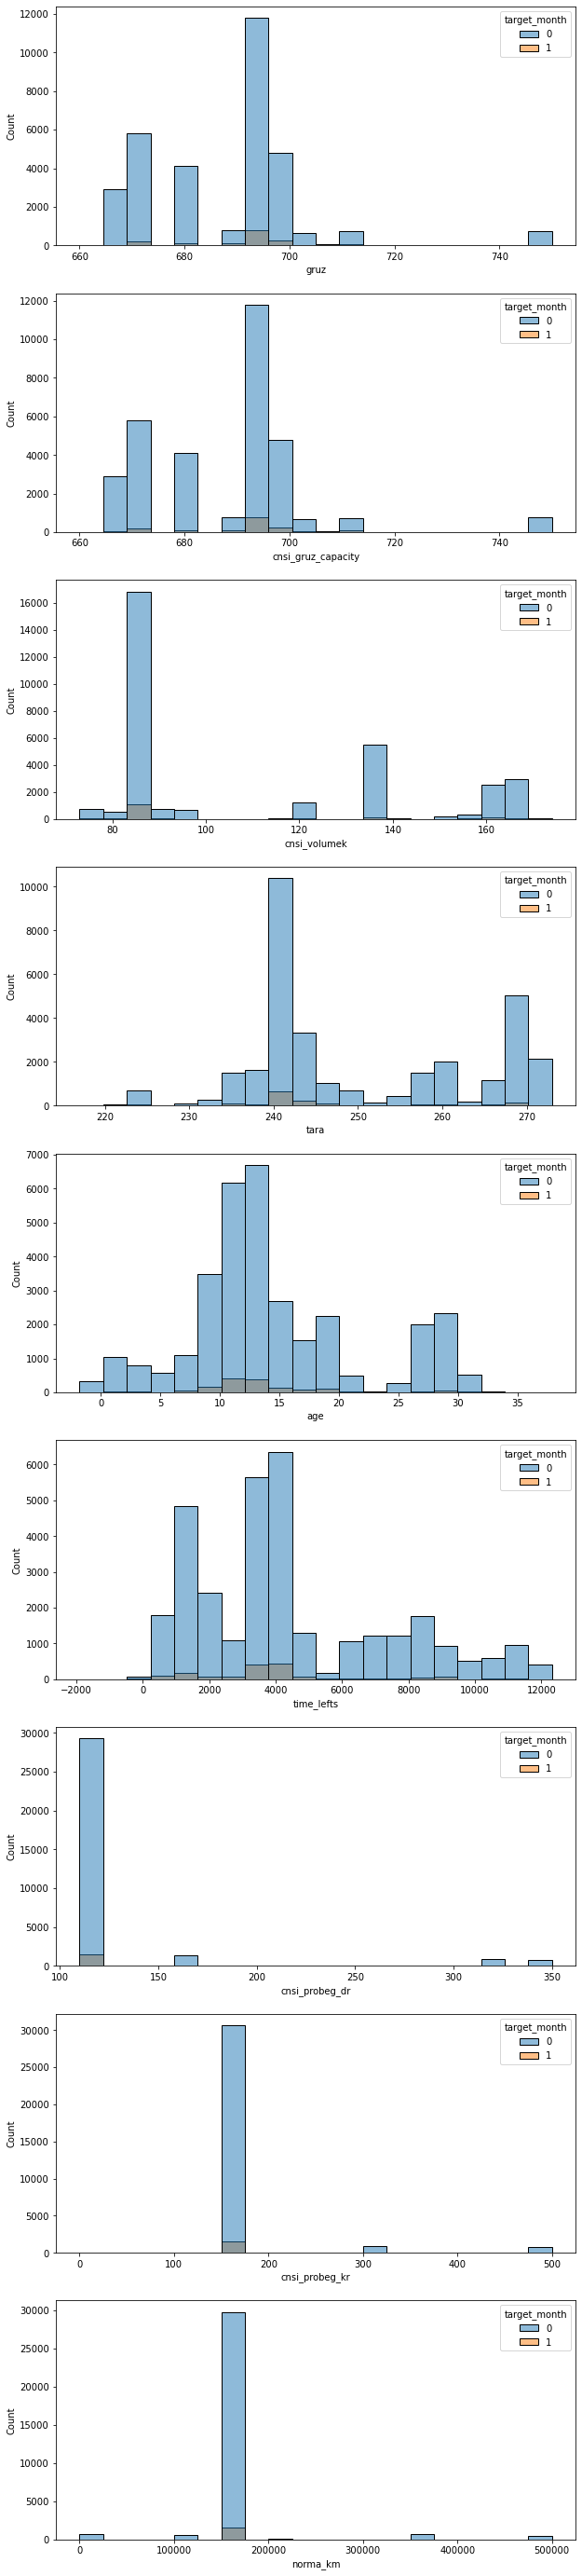

In [292]:
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 50))
for col in enumerate(numeric_cols):
    sns.histplot(data = wag_param, x = col[1], hue = 'target_month', bins = 20,  ax = axes[col[0]])

In [293]:
correlation = wag_param[numeric_cols].corr(method = 'spearman')
text = [[get_spearman(wag_param[i], wag_param[j]) for i in numeric_cols] for j in numeric_cols]

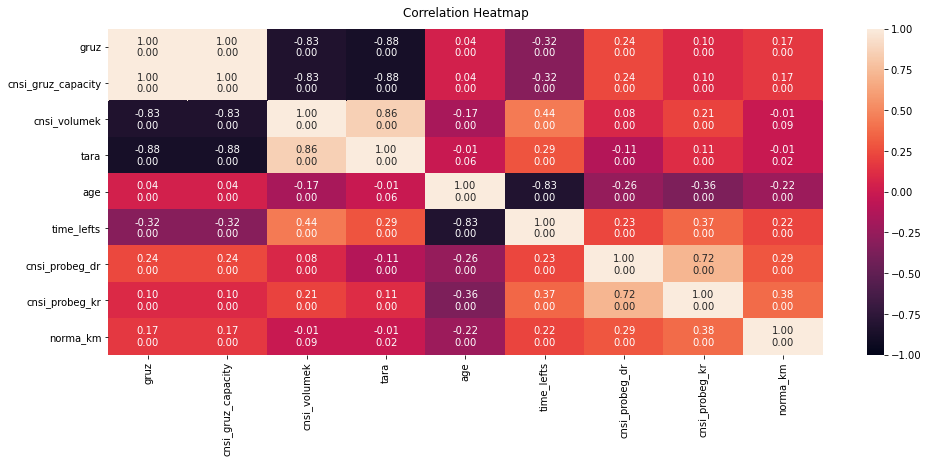

In [443]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot=text, fmt='' )
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig("coor_m.jpeg")

In [295]:
val = wag_param.target_month.unique()

In [296]:
numeric_cols_1 = ['gruz', 
          'age', 
          'time_lefts', 
          'cnsi_probeg_dr', 
         'norma_km'
               ]

In [389]:
# Проверка влияет ли количественный показатель на результат или нет. 
# Тестирование на нормальность распределений в каждой группе
# Тест средних (медиан) для двух независимых выборок. 
# Тестирование дисперсий

result = {}
for column in numeric_cols_1:
    groups = [list(wag_param[wag_param.target_month == i][column].values) for i in val ]
  #  print( [np.median(gr) for gr in groups])
    if any([kstest(i, 'norm').pvalue<0.05 for i in groups]): 
        result[column] = [[np.mean(gr) for gr in groups], [np.median(gr) for gr in groups], mannwhitneyu(*groups, alternative = 'two-sided'), levene(*groups, center='median')]
    else: 
        result[column] = [ [gr.mean() for gr in groups], ttest_ind(*groups), levene(*groups, center='mean')]
result

{'gruz': [[688.5644120643349, 691.7752525252525],
  [695.0, 695.0],
  MannwhitneyuResult(statistic=21872982.5, pvalue=1.5930470135009122e-24),
  LeveneResult(statistic=196.93620306284322, pvalue=1.2976650169351981e-44)],
 'age': [[14.458000185225202, 13.99286616161616],
  [12.8, 12.55],
  MannwhitneyuResult(statistic=26105196.0, pvalue=0.2378138890158762),
  LeveneResult(statistic=117.46054610699524, pvalue=2.5227530372915174e-27)],
 'time_lefts': [[4418.631525329546, 3925.1092171717173],
  [3813.0, 3745.0],
  MannwhitneyuResult(statistic=27209587.0, pvalue=4.545283062905581e-05),
  LeveneResult(statistic=165.9080117004986, pvalue=7.107099052131572e-38)],
 'cnsi_probeg_dr': [[123.89497730991263, 113.13131313131314],
  [110.0, 110.0],
  MannwhitneyuResult(statistic=26793362.0, pvalue=3.735087679932846e-09),
  LeveneResult(statistic=71.8321198551114, pvalue=2.4361678432126282e-17)],
 'norma_km': [[165006.63723643997, 158926.7676767677],
  [160000.0, 160000.0],
  MannwhitneyuResult(statis

In [299]:
result = {}
for column in numeric_cols_1:
    groups = [list(wag_param[wag_param.target_day == i][column].values) for i in val ]
  #  print( [np.median(gr) for gr in groups])
    if any([kstest(i, 'norm').pvalue<0.05 for i in groups]): 
        result[column] = [[np.mean(gr) for gr in groups], [np.median(gr) for gr in groups], mannwhitneyu(*groups, alternative = 'two-sided'), levene(*groups, center='median')]
    else: 
        result[column] = [ [gr.mean() for gr in groups], ttest_ind(*groups), levene(*groups, center='mean')]

result

{'gruz': [[688.6796180441224, 690.7350877192982],
  [695.0, 695.0],
  MannwhitneyuResult(statistic=8674062.5, pvalue=0.0001719346325851077),
  LeveneResult(statistic=47.88059638343739, pvalue=4.6100320657314605e-12)],
 'age': [[14.45903553147544, 13.104736842105265],
  [12.8, 12.0],
  MannwhitneyuResult(statistic=10527862.0, pvalue=1.4490180899313612e-05),
  LeveneResult(statistic=55.175710903912815, pvalue=1.1280744920363229e-13)],
 'time_lefts': [[4396.778309935044, 4327.949122807017],
  [3807.0, 3856.0],
  MannwhitneyuResult(statistic=9303024.5, pvalue=0.34787872202619463),
  LeveneResult(statistic=31.832456775485813, pvalue=1.6939607234181434e-08)],
 'cnsi_probeg_dr': [[123.57440057472985, 112.7719298245614],
  [110.0, 110.0],
  MannwhitneyuResult(statistic=10041000.0, pvalue=9.790773954317902e-06),
  LeveneResult(statistic=26.814887304945017, pvalue=2.2518050241656077e-07)],
 'norma_km': [[164815.45783817762, 159315.7894736842],
  [160000.0, 160000.0],
  MannwhitneyuResult(statist

### Номинативные признаки

In [301]:
wag_param.groupby('rod_id').apply(lambda x: x.groupby(['norma_km','cnsi_probeg_dr', 'cnsi_probeg_kr']).agg('size'))

rod_id  norma_km  cnsi_probeg_dr  cnsi_probeg_kr
0       0         110             160                 269
                  160             160                  10
                  320             320                 459
        110000    110             160                 442
        160000    110             160               11421
                  160             160                  50
        210000    110             160                  50
        320000    320             320                   1
        500000    320             320                 490
1       0         110             160                  11
        110000    110             160                 186
                  160             0                     4
                                  160                  10
        160000    110             160               18400
                  160             0                    33
                                  160                1387
        250000    250  

In [302]:
wag_param.groupby('rod_id').apply(lambda x: x.groupby('norma_km')['model'].count())

rod_id  norma_km
0       0             738
        110000        442
        160000      11471
        210000         50
        320000          1
        500000        490
1       0              11
        110000        200
        160000      19820
        250000          1
        350000        753
Name: model, dtype: int64

In [303]:
wag_param.groupby('rod_id').apply(lambda x: x.groupby('cnsi_probeg_dr')['model'].count())

rod_id  cnsi_probeg_dr
0       110               12182
        160                  60
        320                 950
1       110               18597
        160                1434
        250                   1
        350                 753
Name: model, dtype: int64

In [304]:
wag_param.groupby('rod_id').apply(lambda x: x.groupby('cnsi_probeg_kr')['model'].count())

rod_id  cnsi_probeg_kr
0       160               12242
        320                 950
1       0                    37
        160               19994
        500                 754
Name: model, dtype: int64

In [ ]:
# сохранение гистограмм для презентации (критерий для идентификации)
for_plot = wag_param.groupby(['target_day', 'cnsi_probeg_kr']).agg(size=('cnsi_probeg_kr', 'size')).reset_index()
sns.barplot(data = for_plot, x = 'cnsi_probeg_kr', y ='size', hue = 'target_day' )
plt.savefig("cnsi_probeg_kr_day.png")

In [321]:
wag_param['norma_km_nom'] = wag_param['norma_km'].apply(lambda x: 1 if x == 160000 else (2 if x==0 else 0))
wag_param['cnsi_probeg_dr_nom'] = wag_param['cnsi_probeg_dr'].apply(lambda x: 1 if x == 110 else 0)
wag_param['cnsi_probeg_kr_nom'] = wag_param['cnsi_probeg_kr'].apply(lambda x: 1 if x == 160 else 0)

In [322]:
nominative_list = [
    'rod_id', 
    'zavod_build', 
    'kuzov', 
    'telega', 
    'tormoz', 
    'tipvozd', 
    'tippogl',
    'ownertype', 
    'wag_expired', 
    'in_use', 
    'norma_km_nom', 
    'cnsi_probeg_dr_nom', 
    'cnsi_probeg_kr_nom']

In [323]:
# Тестирование влияния с помощию Хи квадрата. 
#Сравнение распределений частот фактических и ожидаемых
crit_1 = 'target_month'

for crit_2 in nominative_list:
    ct = pd.crosstab(
        wag_param[crit_1],
        wag_param[crit_2])
    ct2 = pd.crosstab(
        wag_param[crit_1],
        wag_param[crit_2], normalize = 'columns')
    
    print(crit_2, '\n Кросс таблица \n', ct,'\n', ct2, '\n p-value:', round(chi2_contingency(ct)[1],2), '\n')

rod_id 
 Кросс таблица 
 rod_id            0      1
target_month              
0             12843  19550
1               349   1235 
 rod_id               0         1
target_month                    
0             0.973545  0.940582
1             0.026455  0.059418 
 p-value: 0.0 

zavod_build 
 Кросс таблица 
 zavod_build      0     1     2   3    4    5     6   7    8    9   ...  14  \
target_month                                                       ...       
0             14932  9145  1267  78  145  187  1146   5  294  329  ...   5   
1               824   308    67   9   15   22   139   2   26    4  ...   1   

zavod_build    15  16    17   18  19   20  21  22  23  
target_month                                           
0             693  50  2685  137  56  351  82   1   1  
1              17   6    37    1   8   28   6   0   0  

[2 rows x 24 columns] 
 zavod_build         0         1         2         3        4         5   \
target_month                                     

In [440]:
crit_1 = 'target_day'

for crit_2 in nominative_list:
    ct = pd.crosstab(
        wag_param[crit_1],
        wag_param[crit_2])
    ct2 = pd.crosstab(
        wag_param[crit_1],
        wag_param[crit_2], normalize = 'columns')
    
    print(crit_2, '\n Кросс таблица \n', ct,'\n', ct2, '\n p-value:', round(chi2_contingency(ct)[1],2), '\n')

rod_id 
 Кросс таблица 
 rod_id          0      1
target_day              
0           13049  20358
1             143    427 
 rod_id            0         1
target_day                   
0           0.98916  0.979456
1           0.01084  0.020544 
 p-value: 0.0 

zavod_build 
 Кросс таблица 
 zavod_build     0     1     2   3    4    5     6   7    8    9   ...  14  \
target_day                                                        ...       
0            15472  9332  1314  85  155  204  1227   6  311  330  ...   6   
1              284   121    20   2    5    5    58   1    9    3  ...   0   

zavod_build   15  16    17   18  19   20  21  22  23  
target_day                                            
0            705  53  2707  138  60  367  85   1   1  
1              5   3    15    0   4   12   3   0   0  

[2 rows x 24 columns] 
 zavod_build        0       1         2         3        4         5   \
target_day                                                             
0       

#### Завод постройки

In [431]:
ct_2 = pd.crosstab(
        wag_param['zavod_build'],
        wag_param['target_day'], normalize = 'index')

In [432]:
zavod_type = dict(ct_2[1].apply(lambda x: 0 if x<0.01 else 1 if x<0.07 else 2))
wag_param['zavod_type'] = wag_param.zavod_build.map(zavod_type)

In [433]:
crit_3 = 'zavod_type'
ct = pd.crosstab(
        wag_param[crit_1],
        wag_param[crit_3])
ct2 = pd.crosstab(
        wag_param[crit_1],
        wag_param[crit_3], normalize = 'columns')
    
print(crit_2, '\n Кросс таблица \n', ct,'\n', ct2, '\n p-value:', round(chi2_contingency(ct)[1],2), '\n')

zavod_build 
 Кросс таблица 
 zavod_type     0      1  2
target_day                
0           4055  29346  6
1             24    545  1 
 zavod_type         0         1         2
target_day                              
0           0.994116  0.981767  0.857143
1           0.005884  0.018233  0.142857 
 p-value: 0.0 



#### Телега

In [436]:
wag_param['telega_type'] = wag_param.telega.map({2:0, 9:0, 27:1, 11:1})

In [441]:
crit_3 = 'telega_type'
ct = pd.crosstab(
        wag_param[crit_1],
        wag_param[crit_3])
ct2 = pd.crosstab(
        wag_param[crit_1],
        wag_param[crit_3], normalize = 'columns')
    
print(crit_3, '\n Кросс таблица \n', ct,'\n', ct2, '\n p-value:', round(chi2_contingency(ct)[1],2), '\n')

telega_type 
 Кросс таблица 
 telega_type      0     1
target_day              
0            31705  1702
1              568     2 
 telega_type       0         1
target_day                   
0            0.9824  0.998826
1            0.0176  0.001174 
 p-value: 0.0 



## Пропуски в date_iskl

In [49]:
iskl = wag_param[wag_param.date_iskl.notnull()]
iskl_join = iskl.set_index('wagnum').join(y_target.set_index('wagnum'), on = 'wagnum', how = 'inner')

In [65]:
print( 'вероятность непопадания в ремонт месяц \n', iskl_join.target_month.agg(['mean','size']))
print('')
print( 'вероятность непопадания в ремонт день\n', iskl_join.target_day.agg(['mean','size']))

вероятность непопадания в ремонт месяц 
 mean      0.086207
size    116.000000
Name: target_month, dtype: float64

вероятность непопадания в ремонт день
 mean      0.008621
size    116.000000
Name: target_day, dtype: float64


## Пропуски в tippogl

Стоит сначала посмотреть на ненулевых данных влияет или нет.

In [74]:
wag_param[wag_param.tippogl.isnull()]

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
1306,1012,11-1807-01,0,667,667,165.0,271,2012-05-18,2044-09-27,17,NaT,110,160,2,9,2,7,<NA>,160000,0
1816,994,11-1807-01,0,667,667,165.0,271,2014-06-08,2044-04-06,17,NaT,110,160,2,9,2,7,<NA>,160000,0
3064,940,11-1807-01,0,667,667,165.0,271,2011-12-21,2046-02-08,17,NaT,110,160,2,9,2,7,<NA>,160000,0
3426,1029,11-1807-01,0,667,667,165.0,271,2015-02-18,2045-04-13,17,NaT,110,160,2,9,2,7,<NA>,160000,0
3801,1060,11-1807-01,0,667,667,165.0,271,2014-04-29,2045-06-15,17,NaT,110,160,2,9,2,7,<NA>,160000,0
5714,928,11-1807-01,0,667,667,165.0,271,2013-02-03,2044-08-26,17,NaT,110,160,2,9,2,6,<NA>,160000,0
5715,1061,11-1807-01,0,667,667,165.0,271,2013-04-01,2047-05-15,17,NaT,110,160,2,9,2,7,<NA>,160000,0
5990,995,11-1807-01,0,667,667,165.0,271,2014-01-13,2045-06-15,17,NaT,110,160,2,9,2,7,<NA>,160000,0
6701,950,11-1807-01,0,667,667,165.0,271,2013-07-14,2044-11-22,17,NaT,110,160,2,9,2,7,<NA>,160000,0
6977,1045,11-1807-01,0,667,667,165.0,271,2013-11-20,2044-09-08,17,NaT,110,160,2,9,2,7,<NA>,160000,0
